# Programming for Data Science and Artificial Intelligence

## Deep Learning - NLP + TorchText + Embedding + LSTM + Self-Attention

Here we shall improve the previous one by adding self attention unit to our LSTM.   Self-attention is referring the self-attention between output from LSTM(all hidden states) and itself.

In [1]:
import torchtext
import torch
from torch import nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


### Loading the dataset

In [2]:
# #uncomment this if you are not using puffer
# import os
# os.environ['http_proxy'] = 'http://192.41.170.23:3128'
# os.environ['https_proxy'] = 'http://192.41.170.23:3128'

from torchtext.datasets import IMDB
train_iter, test_iter = IMDB(split=('train', 'test'))

### Tokenizing

In [3]:
#pip install spacy
#python -m spacy download en_core_web_sm
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
tokens = tokenizer("We are learning torchtext in U.K.!")  #some test
tokens

['We', 'are', 'learning', 'torchtext', 'in', 'U.K.', '!']

### Text to integers

In [4]:
from torchtext.vocab import build_vocab_from_iterator
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=['<unk>', '<pad>', '<bos>', '<eos>'])
vocab.set_default_index(vocab["<unk>"])

In [5]:
#see some example
vocab(['here', 'is', 'a', 'unknownword', 'a'])

[164, 11, 8, 0, 8]

In [6]:
len(vocab)

121068

### ** FastText Embeddings **

We will first download the pre-trained vectors, here I am using FastText.  Then we will get all the FastText embeddings that exist in the vocab.  

In [7]:
#https://github.com/pytorch/text/issues/1350
from torchtext.vocab import FastText
fast_vectors = FastText('simple')

In [8]:
fast_embedding = fast_vectors.get_vecs_by_tokens(vocab.get_itos()).to(device)
# vocab.get_itos() returns a list of strings (tokens), where the token at the i'th position is what you get from doing vocab[token]
# get_vecs_by_tokens gets the pre-trained vector for each string when given a list of strings
# therefore pretrained_embedding is a fully "aligned" embedding matrix

In [9]:
fast_embedding.shape   #we have 121068 vocabs, each with a 300d fasttext embedding

torch.Size([121068, 300])

### Defining hyperparameters

In [10]:
#model hyperparameters
input_dim = len(vocab)
hidden_dim = 256
embed_dim = 300 #**<----cannot change if you are using FastText because that's the dimension of FastText
output_dim = 1
pad_idx = vocab['<pad>'] #++<----making sure our embedding layer ignores pad
num_layers = 2
bidirectional = True
dropout = 0.5

#training hyperparameters
batch_size = 32
num_epochs = 5
lr=0.0001

### Batch Iterator

In [11]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: 1 if x == 'pos' else 0

In [12]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence #++

def collate_batch(batch):
    label_list, text_list, length_list = [], [], []
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        length_list.append(processed_text.size(0))  #++<-----packed padded sequences require length
    #criterion expects float labels
    return torch.tensor(label_list, dtype=torch.float64), pad_sequence(text_list, padding_value=pad_idx, batch_first=True), torch.tensor(length_list, dtype=torch.int64)

In [13]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

train_iter, test_iter = IMDB()
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)
num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = \
    random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_loader = DataLoader(split_train_, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(split_valid_, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                             shuffle=True, collate_fn=collate_batch)

### ++ About pack padded sequence ++
By packing the padded sequence, the RNN (RNN, LSTM, GRU) does not need to do unnecessary computations.

In [14]:
a = [torch.tensor([1,2,3]), torch.tensor([3,4])]
b = torch.nn.utils.rnn.pad_sequence(a)
b

tensor([[1, 3],
        [2, 4],
        [3, 0]])

In [15]:
c = torch.nn.utils.rnn.pack_padded_sequence(b, lengths=[3,2])
c

PackedSequence(data=tensor([1, 3, 2, 4, 3]), batch_sizes=tensor([2, 2, 1]), sorted_indices=None, unsorted_indices=None)

### Build the model

Now we will incorporate Attention mechanism in our LSTM model.  We based on attention mechanisms     https://arxiv.org/abs/1706.03762 but using only the Encoder side, and also with no multihead.

In [16]:
import torch.nn as nn

#this attention mask will be apply after Q @ K^T thus the shape will be batch, seq_len, seq_len
def get_pad_mask(text):  #[batch, seq_len]
    batch_size, seq_len = text.size()
    # eq(zero) is lstm output over PAD token
    pad_mask = text.data.eq(0).unsqueeze(1)  # batch_size x 1 x seq_len; we unsqueeze so we can make expansion below
    return pad_mask.expand(batch_size, seq_len, seq_len)  # batch_size x seq_len x seq_len

class LSTM(nn.Module):
    def __init__(self, len_reduction='mean'):
        super().__init__()
        #put padding_idx so asking the embedding layer to ignore padding
        self.embedding = nn.Embedding(input_dim, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, 
                           hidden_dim, 
                           num_layers=num_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.softmax       = nn.LogSoftmax(dim=1)
        self.len_reduction = len_reduction
        self.lin_Q = nn.Linear(hidden_dim * 2, hidden_dim * 2)
        self.lin_K = nn.Linear(hidden_dim * 2, hidden_dim * 2)
        self.lin_V = nn.Linear(hidden_dim * 2, hidden_dim * 2)
        
    # lstm_output : [batch_size, seq len, n_hidden * num_directions(=2)]
    def self_attention_net(self, lstm_output, pad_mask):
        q = self.lin_Q(torch.clone(lstm_output))
        k = self.lin_K(torch.clone(lstm_output))
        v = self.lin_V(torch.clone(lstm_output))
        # q : [batch_size, seq_len, n_hidden * num_directions(=2)]
        # k.transpose(1, 2): [batch_size, n_hidden * num_directions(=2), seq_len]
        # attn_w = [batch_size, seq_len, seq_len]
                
        attn_w = torch.matmul(q, k.transpose(1, 2))
                
        #apply padding mask 
        if self.mask:
            attn_w.masked_fill_(pad_mask, -1e9) # Fills elements of self tensor with value where mask is one.

        sfmx_attn_w = self.softmax(attn_w)
        # context = [batch_size, seq_len, hidden_dim * num_directions(=2)]
        context = torch.matmul(sfmx_attn_w, v)
        if self.len_reduction == "mean":
            return torch.mean(context, dim=1), sfmx_attn_w.cpu().data.numpy()
        elif self.len_reduction == "sum":
            return torch.sum(context, dim=1), sfmx_attn_w.cpu().data.numpy()
        elif self.len_reduction == "last":
            return context[:, -1, :], sfmx_attn_w.cpu().data.numpy()
        
    def forward(self, text, text_lengths, mask=True):
        
        self.mask = mask
        pad_mask = get_pad_mask(text)
        
        #text = [batch size, seq len]
        embedded = self.embedding(text)
        
        #++ pack sequence ++
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'), enforce_sorted=False, batch_first=True)
        
        #embedded = [batch size, seq len, embed dim]
        packed_output, (hn, cn) = self.lstm(packed_embedded)  #if no h0, all zeroes
        
        #++ unpack in case we need to use it ++
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        
        #output = [batch size, seq len, hidden dim * num directions]
        #output over padding tokens are zero tensors
                
        attn_output, attention  = self.self_attention_net(output, pad_mask)
                
        #attn_output = [batch_size, hidden_dim * num_direction(=2)]
        return self.fc(attn_output), attention

In [17]:
#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.RNN):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param) #<---here

In [18]:
w = torch.empty(3, 5)
nn.init.orthogonal_(w)

tensor([[-0.4193,  0.4111,  0.0886,  0.0538, -0.8028],
        [ 0.8090,  0.5259, -0.0537,  0.2123, -0.1449],
        [-0.1486,  0.1594,  0.7541,  0.5529,  0.2795]])

In [19]:
model = LSTM().to(device)
model.apply(initialize_weights)
model.embedding.weight.data = fast_embedding #**<------applied the fast text embedding as the initial weights

In [20]:
#we can print the complexity by the number of parameters
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

39828625


### Training

In [21]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=lr) #<----changed to Adam
criterion = nn.BCEWithLogitsLoss() #combine sigmoid with binary cross entropy

In [22]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [23]:
def train(model, loader, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout
    for i, (label, text, text_length) in enumerate(loader): 
        label = label.to(device) #(batch_size, )
        text = text.to(device) #(batch_size, seq len)
                
        #predict
        predictions, attention = model(text, text_length) #output by the fc is (batch_size, 1), thus need to remove this 1
        predictions = predictions.squeeze(1)
        
        #calculate loss
        loss = criterion(predictions, label)
        acc = binary_accuracy(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [24]:
def evaluate(model, loader, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (label, text, text_length) in enumerate(loader): 
            label = label.to(device) #(batch_size, )
            text = text.to(device) #(batch_size, seq len)

            predictions, attention = model(text, text_length)
            predictions = predictions.squeeze(1)
            
            loss = criterion(predictions, label)
            acc = binary_accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

### Putting everything together

In [25]:
best_valid_loss = float('inf')

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'models/fasttext_BiLSTM_self_attention.pt')
    
    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Train Loss: 3.911 | Train Acc: 67.43%
	 Val. Loss: 1.148 |  Val. Acc: 73.91%
Epoch: 02 | Train Loss: 1.718 | Train Acc: 76.38%
	 Val. Loss: 0.917 |  Val. Acc: 82.11%
Epoch: 03 | Train Loss: 0.962 | Train Acc: 82.88%
	 Val. Loss: 1.019 |  Val. Acc: 81.95%
Epoch: 04 | Train Loss: 1.169 | Train Acc: 84.20%
	 Val. Loss: 1.006 |  Val. Acc: 84.61%
Epoch: 05 | Train Loss: 0.675 | Train Acc: 88.22%
	 Val. Loss: 0.717 |  Val. Acc: 88.75%


Text(0, 0.5, 'loss')

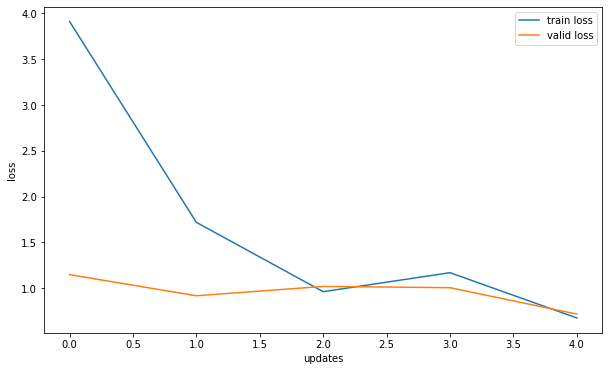

In [26]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

Text(0, 0.5, 'acc')

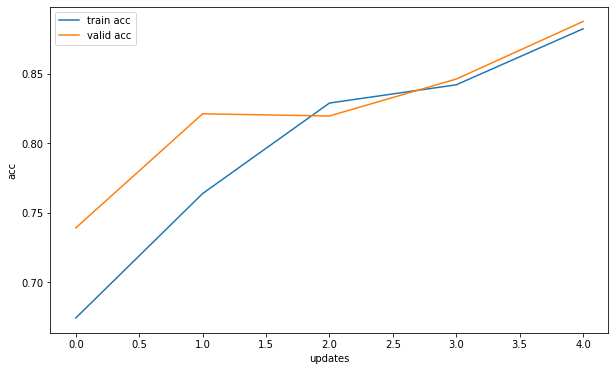

In [27]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')

In [30]:
model.load_state_dict(torch.load('models/fasttext_BiLSTM_self_attention.pt'))
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.974 | Test Acc: 85.98%


### Test on some random reviews

In [31]:
test_str = "This is Chaky.  This movie is really terrible"
text = torch.tensor(text_pipeline(test_str)).to(device)
text

tensor([ 68,  11,   0,   6,   0,  68,  24,  11,  79, 450], device='cuda:0')

In [32]:
text = text.reshape(1, -1)  #because batch_size is 1

In [33]:
text_length = torch.tensor([text.size(1)]).to(dtype=torch.int64)

In [34]:
text.shape

torch.Size([1, 10])

In [35]:
text_length.shape

torch.Size([1])

In [36]:
def predict(text, text_pipeline):
    model.eval()
    with torch.no_grad():
        output, attention = model(text, text_length)
        output = output.squeeze(1)
        rounded_preds = torch.round(torch.sigmoid(output))
        return rounded_preds

In [37]:
predict(text, text_pipeline)  #quite accurate!!! try change to opposite

tensor([0.], device='cuda:0')